# Exemple de connexion a la base de donnée.

Pour l'use créez un fichier .env et dedans mettez :  
DB_HOST=  
DB_USER=  
DB_PASSWORD=  
DB_NAME=grape-mind  

In [18]:
import os
from dotenv import load_dotenv
import mysql.connector

load_dotenv()

def get_connection():
    return mysql.connector.connect(
        host=os.getenv("DB_HOST"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        database=os.getenv("DB_NAME")
    )

conn = get_connection()

cursor = conn.cursor()

# verif que bien connecté
cursor.execute("SELECT * FROM descriptifs LIMIT 5;")
rows = cursor.fetchall()
for row in rows:
    print(row)

#cursor.close()
#conn.close()

(101068, 'Sparkling', 'Assemblage/Blend', "['Chardonnay', 'Pinot Noir']", "['Pork', 'Rich Fish', 'Shellfish', 'Soft Cheese']", 12.0, 'Medium-bodied', 'High', 'FR', 'France', 1201, 'Champagne Premier Cru', 10412, 'Cave Geisse', 'http://www.cavegeisse.com.br', '[2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2002, 2000, 1998]', 'Philippe Dumont Champagne Brut Réserve Premier CruCave Geisse', None, None)
(103981, 'Rosé', 'Assemblage/Blend', "['Syrah/Shiraz', 'Grenache']", "['Pasta', 'Vegetarian', 'Appetizer', 'Snack', 'Lean Fish']", 12.5, 'Full-bodied', 'High', 'FR', 'France', 1398, "Pays d'Oc", 11889, 'Scanivinus', None, '[2020, 2019, 2018, 2014]', 'GW:s RosaScanivinus', None, None)
(105953, 'White', 'Assemblage/Blend', "['Chardonnay', 'Sauvignon Blanc']", "['Pork', 'Rich Fish', 'Shellfish', 'Vegetarian', 'Poultry']", 12.5, 'Full-bodied', 'High', 'FR', 'France', 1125, 'Alsace', 11877, 'Le Saumon', None, '[2018, 2017, 2016]', 'Organic Chardonnay-Sauvignon BlancLe 

# 💵 Régression entre le Prix et la Note Moyenne

/var/folders/b7/wf1jpwfd07364xk2zspsk8340000gn/T/ipykernel_93740/157401708.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)



Output de la regression lineaire :
Coeff : 0.00027975925235126134
Intercept : 3.852044539488812
R^2 : 0.07833648846257513


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


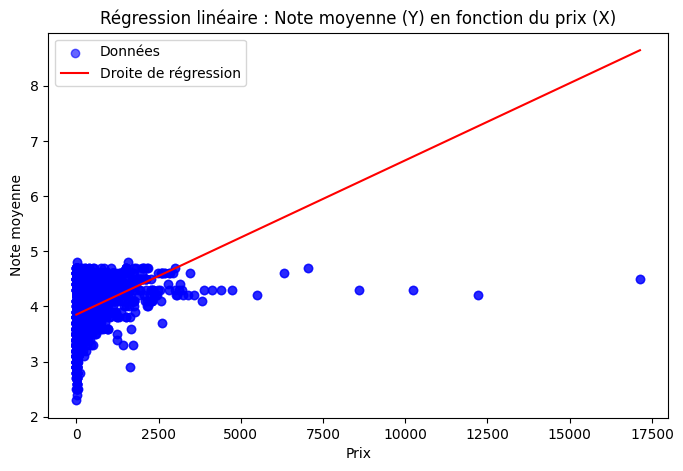

In [15]:
import os
from dotenv import load_dotenv
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

load_dotenv()

def get_connection():
    return mysql.connector.connect(
        host=os.getenv("DB_HOST"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        database=os.getenv("DB_NAME")
    )
conn = get_connection()

query = """
SELECT price, average_rating
FROM scrap
"""  

df = pd.read_sql(query, conn)

df.dropna(subset=['price', 'average_rating'], inplace=True)

# je filtres sinon c'est le bordel y a des vins a + de 100k€ 
df = df[(df['price'] <= 20000) & (df['average_rating'] <= 5)]

X = df[['price']]  
y = df['average_rating']  

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
intercept = model.intercept_
coef = model.coef_[0]
r2 = r2_score(y, y_pred)

print("\nOutput de la regression lineaire :")
print("Coeff :", coef)
print("Intercept :", intercept)
print("R^2 :", r2_score(y, y_pred))


plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', alpha=0.6, label='Données')

x_range = np.linspace(X['price'].min(), X['price'].max(), 100).reshape(-1, 1)
y_range_pred = model.predict(x_range)
plt.plot(x_range, y_range_pred, color='red', label='Droite de régression')

plt.xlabel('Prix')
plt.ylabel('Note moyenne')
plt.title('Régression linéaire : Note moyenne (Y) en fonction du prix (X)')
plt.legend()
plt.show()


*Alternative proposée par GPT :*  
Régression linéaire avec __**Statsmodels OLS**__ pour prédire `average_rating` en fonction du `prix`, en affichant un résumé statistique du modèle.  Il trace également un intervalle de confiance à 95% autour des prédictions pour visualiser l'incertitude des estimations.

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     3127.
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:08:21   Log-Likelihood:                -6561.2
No. Observations:               36792   AIC:                         1.313e+04
Df Residuals:                   36790   BIC:                         1.314e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8520      0.002   2452.629      0.0

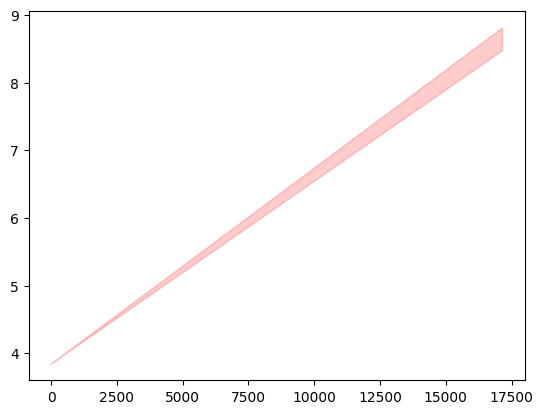

In [16]:
import statsmodels.api as sm

X_sm = df['price']
y_sm = df['average_rating']

X_sm = sm.add_constant(X_sm)

model_sm = sm.OLS(y_sm, X_sm).fit()
print(model_sm.summary())

x_reg = np.linspace(df['price'].min(), df['price'].max(), 100)
X_reg = sm.add_constant(x_reg)

predictions = model_sm.get_prediction(X_reg)
interval_conf = predictions.conf_int()  # par défaut, 95%

y_pred_mean = predictions.predicted_mean
lower_bound = interval_conf[:, 0]
upper_bound = interval_conf[:, 1]

plt.fill_between(x_reg, lower_bound, upper_bound, color='red', alpha=0.2, 
                 label='IC 95%')


# 🍷 Prix du vin influencé par ? (note moyenne, taux d'alcool, type de vin...)

/var/folders/b7/wf1jpwfd07364xk2zspsk8340000gn/T/ipykernel_93740/2094737329.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Intercept  : -891.4713013514599

Coeffs :
average_rating: 267.0581
ABV: -7.3572
Type_Dessert/Port: -9.2763
Type_Red: 49.4019
Type_Rosé: 13.7082
Type_Sparkling: 19.2548
Type_White: 25.6521

R^2 : 0.12309350955839504


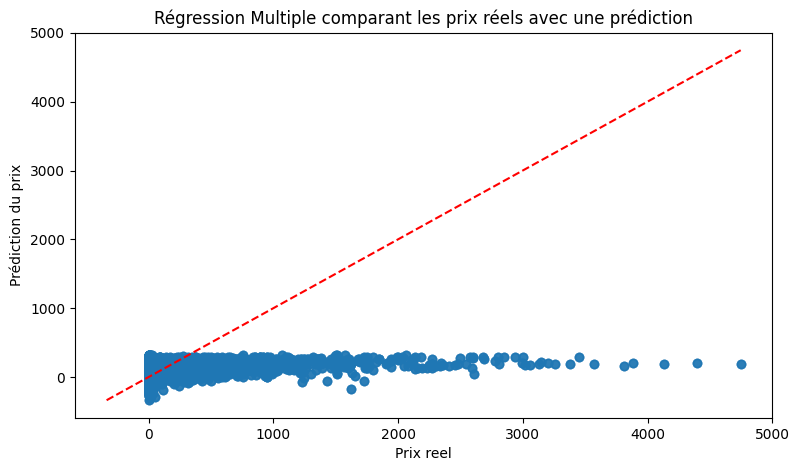

KeyError: 'Coefficient'

<Figure size 1000x500 with 0 Axes>

In [21]:
import os
from dotenv import load_dotenv
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
load_dotenv()

def get_connection():
    return mysql.connector.connect(
        host=os.getenv("DB_HOST"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        database=os.getenv("DB_NAME")
    )

conn = get_connection()

query = """
SELECT 
    s.price,
    s.average_rating,
    d.ABV,
    d.Type
FROM scrap AS s
JOIN descriptifs AS d ON s.idwine = d.idwine
"""

df = pd.read_sql(query, conn)
df = df[df['price'] < 5000]


df.dropna(subset=['price', 'average_rating', 'ABV', 'Type'], inplace=True)

df = pd.get_dummies(df, columns=['Type'], drop_first=True)

X = df.drop(columns=['price'])
y = df['price']


# Regression multiple (scikit-learn)
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

intercept = model.intercept_
coefs = model.coef_

print("Intercept  :", intercept)
print("\nCoeffs :")
for col_name, coef_value in zip(X.columns, coefs):
    print(f"{col_name}: {coef_value:.4f}")

r2 = r2_score(y, y_pred)
print("\nR^2 :", r2)



plt.figure(figsize=(9, 5))
plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel("Prix reel")
plt.ylabel("Prédiction du prix")
plt.title("Régression Multiple comparant les prix réels avec une prédiction")
max_val = max(y.max(), y_pred.max())
min_val = min(y.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.show()

plt.figure(figsize=(10, 5))
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeff': coefs
})
coef_df = coef_df.sort_values('Coeff', ascending=False)

plt.bar(coef_df['Variable'], coef_df['Coefficient'], color='skyblue')
plt.xticks(rotation=45, ha='right')  # Rotation des labels de l'axe X
plt.ylabel("Valeur du coeff")
plt.title("Importance chaque caractéristique sur son influence (du prix)")
plt.tight_layout()
plt.show()


# 🍇 Etude de l'impact du millésime sur la qualité du vin  
On se base ici sur la note donnée dans notre table `all_reviews`


Output de la regression lineaire :
Coeff : 0.032645429256741784
Intercept : 2.4925743143310335
R^2 : 0.019315212310238694


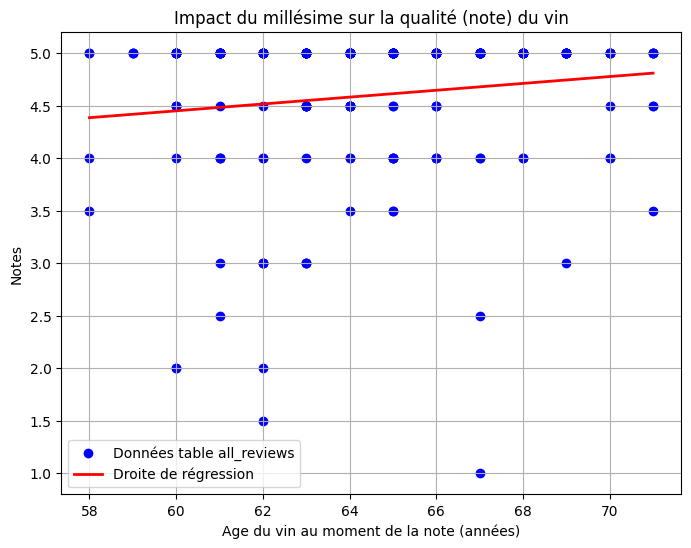

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

cursor.execute("SELECT * FROM all_reviews LIMIT 200;")
data = cursor.fetchall()


df = pd.DataFrame(data, columns=cursor.column_names)


df['Date'] = pd.to_datetime(df['Date'])
df['ReviewYear'] = df['Date'].dt.year

# Conversion pour eviter les erreurs de merde de panda
df['Vintage'] = pd.to_numeric(df['Vintage'], errors='coerce')
df.dropna(subset=['Vintage'], inplace=True)
df['Vintage'] = df['Vintage'].astype(int)

# Calcul de l'age du vin au moment de la review (note)
df['WineAge'] = df['ReviewYear'] - df['Vintage']

X = df[['WineAge']]  # scikit-learn attends un X et Y
y = df['Rating']

# appel et ajustement du modèle sur nos données
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

print("\nOutput de la regression lineaire :")
print("Coeff :", model.coef_[0])
print("Intercept :", model.intercept_)
print("R^2 :", r2_score(y, y_pred))


plt.figure(figsize=(8, 6))
plt.scatter(df['WineAge'], df['Rating'], color='blue', label='Données table all_reviews')
plt.plot(df['WineAge'], y_pred, color='red', linewidth=2, label='Droite de régression')
plt.xlabel("Age du vin au moment de la note (années)")
plt.ylabel("Notes")
plt.title("Impact du millésime sur la qualité (note) du vin")
plt.legend()
plt.grid(True)
plt.show()


/Users/maxime/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


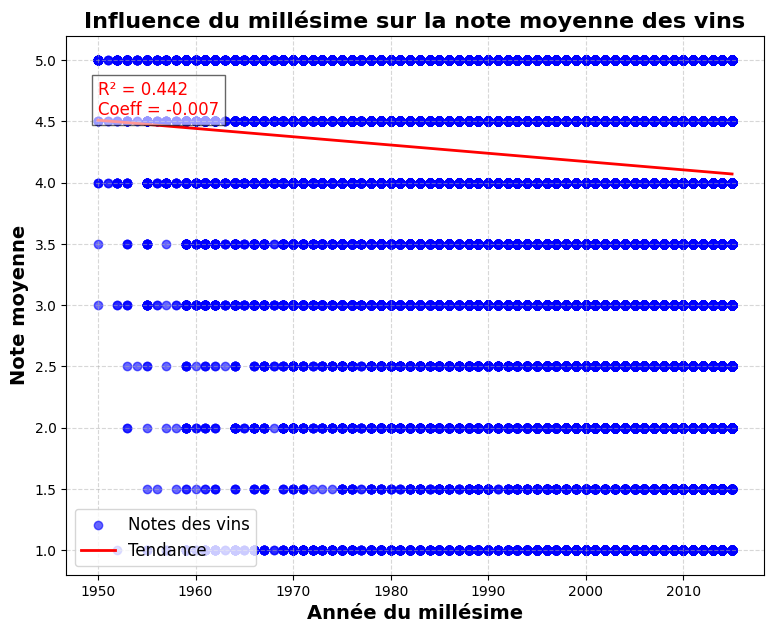

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

cursor.execute("SELECT * FROM all_reviews LIMIT 2000000;")
data = cursor.fetchall()

df = pd.DataFrame(data, columns=cursor.column_names)

df['Date'] = pd.to_datetime(df['Date'])
df['ReviewYear'] = df['Date'].dt.year

df['Vintage'] = pd.to_numeric(df['Vintage'], errors='coerce')
df.dropna(subset=['Vintage'], inplace=True)
df['Vintage'] = df['Vintage'].astype(int)

df_grouped = df.groupby('Vintage')['Rating'].mean().reset_index()

X = df_grouped[['Vintage']]
y = df_grouped['Rating']

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

plt.figure(figsize=(9, 7))
plt.scatter(df['Vintage'], df['Rating'], color='blue', alpha=0.6, label='Notes des vins')
plt.plot(df_grouped['Vintage'], y_pred, color='red', linewidth=2, label='Tendance')

plt.xlabel("Année du millésime", fontsize=14, fontweight='bold')
plt.ylabel("Note moyenne", fontsize=14, fontweight='bold')
plt.title("Influence du millésime sur la note moyenne des vins", fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.text(min(df_grouped['Vintage']), max(df_grouped['Rating']) - 0.2, f"R² = {r2:.3f}\nCoeff = {model.coef_[0]:.3f}",
         fontsize=12, color="red", bbox=dict(facecolor='white', alpha=0.6))

plt.show()